In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
from itertools import cycle
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS

# Suppress the specific TensorFlow warning
warnings.filterwarnings("ignore", message=".*AVX_VNNI FMA.*")

In [2]:

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


    def split_window(self, features):
        """
        Given a list of consecutive inputs, the split_window
        method will convert them to a window of inputs and a
        window of labels.
        """
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, plot_col, model=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        plt.show()


    def make_dataset(self, data):
        """
        This method will take a time series DataFrame and convert
        it to a tf.data.Dataset of (input_window, label_window) pairs using the
        tf.keras.utils.timeseries_dataset_from_array function.
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32, )

        ds = ds.map(self.split_window)

        return ds


    @property
    def train(self):
        return self.make_dataset(self.train_df)


    @property
    def val(self):
        return self.make_dataset(self.val_df)


    @property
    def test(self):
        return self.make_dataset(self.test_df)


    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


In [3]:
def get_data(dataset):
    # Load the training and testing data
    train_data = pd.read_csv(f'{dataset}-train.csv').drop(columns='V1')
    test_data = pd.read_csv(f'{dataset}-test.csv').drop(columns='V1')

    # Fill missing values with the mean of the it's column.
    train_data.fillna(train_data.mean(), inplace=True)
    test_data.fillna(test_data.mean(), inplace=True)

    # remove trend and seasonality
    train_data = preprocess_time_series(train_data)
    test_data = preprocess_time_series(test_data)

    # Drop rows with NaN values (they might appear after detrending)
    train_data = train_data.dropna(how='all')
    test_data = test_data.dropna(how='all')

    return train_data, test_data


def preprocess_time_series(data):
    # Let's remove trend and Seasonality.
    feature_names = data.columns.tolist()
    for feature in feature_names:
        # Removing Trend with OLS
        least_squares = OLS(data[feature].values, list(range(data.shape[0])))
        result = least_squares.fit()
        fit = pd.Series(result.predict(list(range(data.shape[0]))), index=data.index)
        data_ols_detrended = data[feature] - fit
        # Removing Seasonality by Differencing Over Linear Regression Transformed Time-Series
        data_detrended_diff = data_ols_detrended - data_ols_detrended.shift()
        # Saving
        data[feature] = data_detrended_diff
    # Drop rows with NaN values
    data = data.dropna(how='all')

    return data


def compile_and_fit(model, window, max_epochs, patience=2, ):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [4]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: Daily-test.csv          
  inflating: Daily-train.csv         
  inflating: Hourly-test.csv         
  inflating: Hourly-train.csv        
  inflating: Monthly-test.csv        
  inflating: Monthly-train.csv       
  inflating: Quarterly-test.csv      
  inflating: Quarterly-train.csv     
  inflating: Weekly-test.csv         
  inflating: Weekly-train.csv        
  inflating: Yearly-test.csv         
  inflating: Yearly-train.csv        
  inflating: m4_info.csv             


**Data pre-processing**


In [5]:
# fetch datasets (trend and seasonality are filtered)
dataset = 'Daily'
train_data, test_data = get_data(dataset)

# Normalize data
scaler_tr = MinMaxScaler()
scaler_ts = MinMaxScaler()
X_train = scaler_tr.fit_transform(train_data)
X_test = scaler_ts.fit_transform(test_data)
# Convert the NumPy arrays back to Pandas DataFrames
X_train = pd.DataFrame(X_train, columns=train_data.columns)
X_test = pd.DataFrame(X_test, columns=test_data.columns)

# Add a column with one-hot encodings of days,
# assuming that the first record starts from Monday.
# Comment out this part if you're using yearly or hourly dataset.
encodings = [
    [1, 0, 0, 0, 0, 0 ,0], # monday
    [0, 1, 0, 0, 0, 0, 0], # tuesday
    [0, 0, 1 ,0, 0, 0, 0], # wednesday
    [0, 0 ,0, 1 ,0 ,0, 0], # thursday
    [0, 0, 0, 0 ,1, 0, 0], # friday
    [0, 0, 0, 0, 0, 1, 0], # saturday
    [0, 0 ,0, 0, 0, 0, 1]  # sunday
]
encodings_cycle = cycle(encodings)
new_columns = ['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']
# training set:
# add new columns
for column_name in reversed(new_columns):
    X_train.insert(0, column_name, 0)
# replace the new columns values with the encodings
for index, row in X_train.iterrows():
    encoding = next(encodings_cycle)
    X_train.loc[index, X_train.columns[:7]] = encoding
# test set:
# add new columns
encodings_cycle = cycle(encodings)
for column_name in reversed(new_columns):
    X_test.insert(0, column_name, 0)
# replace the new columns values with the encodings
for index, row in X_test.iterrows():
    encoding = next(encodings_cycle)
    X_test.loc[index, X_test.columns[:7]] = encoding

# Split the train_data into training and validation sets
train_ratio = 0.8
validation_ratio = 0.2
X_train, X_val = train_test_split(X_train,
                                test_size=validation_ratio,
                                random_state=42,
                                shuffle=False)

# Convert the NumPy arrays back to Pandas DataFrames
train_df = pd.DataFrame(X_train, columns=X_train.columns)
val_df = pd.DataFrame(X_val, columns=X_train.columns)
test_df = pd.DataFrame(X_test, columns=X_test.columns)

Multi-step model
Inputs shape (batch, time, features): (32, 30, 9926)
Labels shape (batch, time, features): (32, 1, 1)
Epoch 1/20
105/105 [==============================] - 72s 663ms/step - loss: 1548.1262 - mean_absolute_error: 9.3897 - val_loss: 36.4230 - val_mean_absolute_error: 6.0299
Epoch 2/20
105/105 [==============================] - 77s 730ms/step - loss: 2.5921 - mean_absolute_error: 0.9636 - val_loss: 0.0805 - val_mean_absolute_error: 0.2300
Epoch 3/20
105/105 [==============================] - 63s 598ms/step - loss: 0.1883 - mean_absolute_error: 0.3392 - val_loss: 0.4780 - val_mean_absolute_error: 0.6640
Epoch 4/20
26/26 [==============================] - 2s 79ms/step - loss: 0.9485 - mean_absolute_error: 0.9210


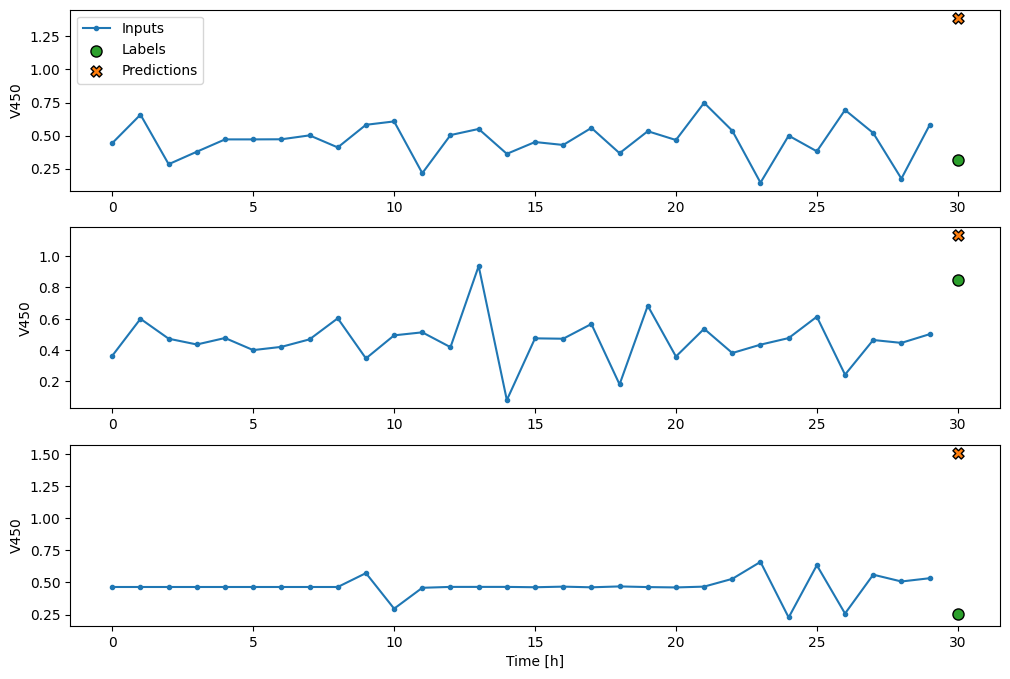

'\nThe main down-side of this approach is that the resulting model can only be executed\non input windows of exactly this shape.\n'

In [6]:
# params.
MAX_EPOCHS = 20
target_labels = ['V450']
val_performance = {}
performance = {}

# Multi-step window
print("Multi-step model")
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=target_labels)
# Multi-layer model
#with tf.device('/GPU:0'):
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
for example_inputs, example_labels in conv_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
history = compile_and_fit(multi_step_dense, conv_window, MAX_EPOCHS)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
conv_window.plot(model=multi_step_dense, plot_col=target_labels[0])

"""
The main down-side of this approach is that the resulting model can only be executed
on input windows of exactly this shape.
"""